In [39]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import os
from math import * 
os.getcwd()
print("The current directory is: ")
print(os.getcwd())
path_parent = os.path.dirname(os.getcwd())
if path_parent.endswith("Abaqus-Macromechanics-Project"):
    os.chdir(path_parent) 
    print("Moving up to the parent directory")
    print(os.getcwd())

The current directory is: 
c:\Users\springnuance\Desktop\Abaqus-Macromechanics-Project


In [40]:
from stage0_configs import *
from modules.SOO_SIM import *
from modules.helper import *
from modules.hardeningLaws import *
info = main_config()

taskName = "A1" # A1 A2 A3 A4

if taskName == "A1":
    info['targetPath'] = "SOO_targets/DP1000_room_Swift_NDBR50_curve2"
    info['resultPath'] = "SOO_results/DP1000_room_Swift_NDBR50_curve2"

if taskName == "A2":
    info['targetPath'] = "SOO_targets/DP1000_room_SwiftVoce_NDBR50_curve2"
    info['resultPath'] = "SOO_results/DP1000_room_SwiftVoce_NDBR50_curve2"

if taskName == "A3":
    info['targetPath'] = "SOO_targets/DP1000_room_SwiftVoce_NDBR50_curve1"
    info['resultPath'] = "SOO_results/DP1000_room_SwiftVoce_NDBR50_curve1"


Welcome to the Abaqus parameter calibration project


The configurations you have chosen: 

+------------------------+----------------+
|     Global Configs     |  User choice   |
+------------------------+----------------+
|    SLURM iteration     | one_node_small |
| Number of initial sims |      100       |
|  Initial sims spacing  |     10000      |
|   Optimize strategy    |      SOO       |
|        Material        |  DP1000_room   |
|     Hardening law      |     Swift      |
|        Geometry        |     NDBR50     |
|      Curve index       |       2        |
|     Optimizer name     |       BO       |
|   Deviation percent    |       2        |
+------------------------+----------------+

Generating necessary directories

The path to your main project folder is

c:\Users\springnuance\Desktop\Abaqus-Macromechanics-Project



In [41]:
# Add column force,N to the target curve
# Create new dataframe
df = pd.DataFrame(columns=['displacement/mm', 'force/kN', 'force/N'])
targetCurve = pd.read_csv(f"{info['targetPath']}/FD_Curve.csv")
df['displacement/mm'] = targetCurve['displacement/mm']
df['force/kN'] = targetCurve['force/N'] * 1e-3
df['force/N'] = targetCurve['force/N']
df.to_csv(f"{info['targetPath']}/FD_Curve.csv",index=False)

# Iteration guess FD curve simulations

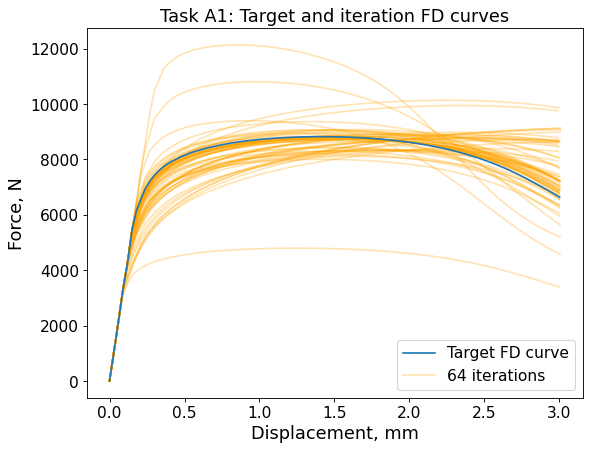

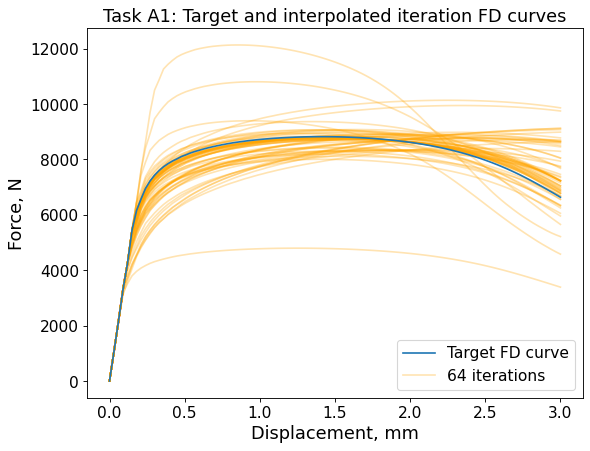

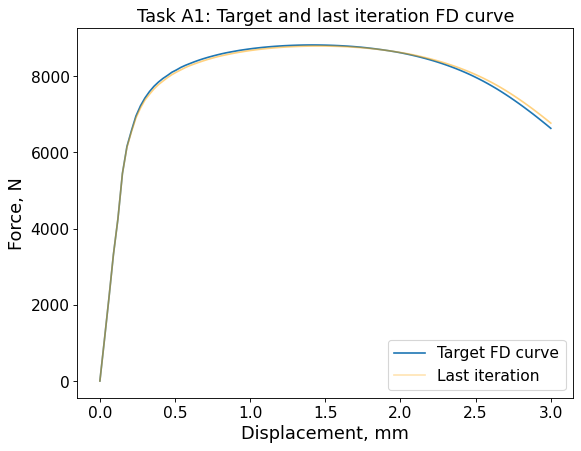

In [42]:
resultPath = info['resultPath']
targetPath = info['targetPath']

targetCurve = pd.read_csv(f"{targetPath}/FD_Curve.csv")
expDisplacement = targetCurve['displacement/mm']
expForce = targetCurve['force/N']

targetCurve = {}
targetCurve['displacement'] = expDisplacement
targetCurve['force'] = expForce

fontsize = 14

iteration_original_FD_Curves = np.load(f"{resultPath}/iteration/common/FD_Curves_smooth.npy", allow_pickle=True).tolist()
figure(figsize=(8, 6), dpi=80)

for param in iteration_original_FD_Curves:
    plt.plot(iteration_original_FD_Curves[param]['displacement'], 
             iteration_original_FD_Curves[param]['force'], 
             color='orange', 
             alpha=0.3,
             #label=param
             )
plt.plot(expDisplacement, expForce, label='Target FD curve')

numberOfIterations = len(iteration_original_FD_Curves)
plt.plot([],[], color='orange', alpha=0.3, label=f'{numberOfIterations} iterations')
plt.title(f'Task {taskName}: Target and iteration FD curves', fontsize=fontsize+2)
plt.xlabel('Displacement, mm', fontsize=fontsize+2)
plt.ylabel('Force, N', fontsize=fontsize+2)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize, loc=4)

##############################

iteration_interpolated_FD_Curves = interpolating_FD_Curves(iteration_original_FD_Curves, targetCurve)

figure(figsize=(8, 6), dpi=80)

for param in iteration_interpolated_FD_Curves:
    plt.plot(iteration_interpolated_FD_Curves[param]['displacement'], 
             iteration_interpolated_FD_Curves[param]['force'], 
             color='orange', 
             alpha=0.3,
             #label=param
             )
plt.plot(expDisplacement, expForce, label='Target FD curve')

numberOfIterations = len(iteration_interpolated_FD_Curves)
plt.plot([],[], color='orange', alpha=0.3, label=f'{numberOfIterations} iterations')
plt.title(f'Task {taskName}: Target and interpolated iteration FD curves', fontsize=fontsize+2)
plt.xlabel('Displacement, mm', fontsize=fontsize+2)
plt.ylabel('Force, N', fontsize=fontsize+2)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize, loc=4)

##############################
figure(figsize=(8, 6), dpi=80)

iter = -1

last_iteration_interpolated_displacement = list(iteration_interpolated_FD_Curves.values())[iter]['displacement']
last_iteration_interpolated_force = list(iteration_interpolated_FD_Curves.values())[iter]['force']

plt.plot(expDisplacement, expForce, label='Target FD curve')
plt.plot(last_iteration_interpolated_displacement, last_iteration_interpolated_force, color='orange', alpha=0.5)
plt.plot([],[], color='orange', alpha=0.3, label='Last iteration')
plt.title(f'Task {taskName}: Target and last iteration FD curve', fontsize=fontsize+2)
plt.xlabel('Displacement, mm', fontsize=fontsize+2)
plt.ylabel('Force, N', fontsize=fontsize+2)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize, loc=4)
plt.show()

# Iteration guess flow curve simulations

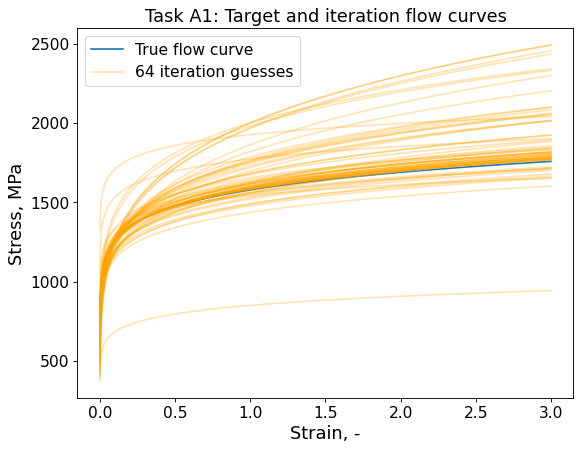

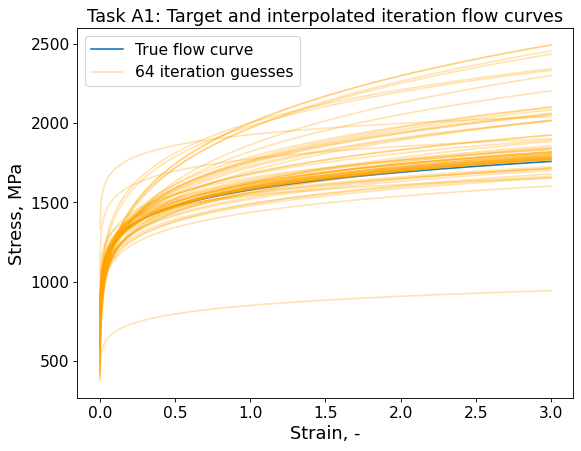

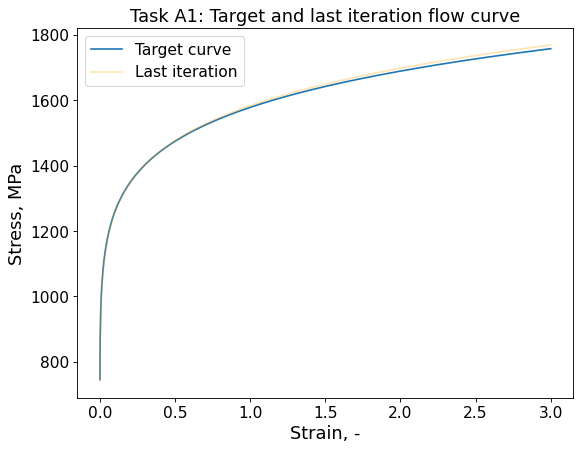

In [43]:
resultPath = info['resultPath']
targetPath = info['targetPath']

target = pd.read_csv(f"{targetPath}/flowCurve.csv")
expStress = target['stress/MPa'].to_numpy()
expStrain = target['strain/-'].to_numpy() 

targetCurve = {}
targetCurve['stress'] = expStress
targetCurve['strain'] = expStrain

iteration_original_flowCurves = np.load(f"{resultPath}/iteration/common/flowCurves.npy", allow_pickle=True).tolist()
iteration_interpolated_flowCurves = interpolating_flowCurves(iteration_original_flowCurves, targetCurve)

fontsize = 14

#############################
figure(figsize=(8, 6), dpi=80)
plt.plot(expStrain, expStress, label='True flow curve')
for param in iteration_original_flowCurves:
    plt.plot(iteration_original_flowCurves[param]['strain'], 
             iteration_original_flowCurves[param]['stress'], 
             color='orange', 
             alpha=0.3,
             #label=param
             )
numberOfIterationSims = len(iteration_original_flowCurves)
plt.plot([],[], color='orange', alpha=0.3, label=f'{numberOfIterationSims} iteration guesses')
plt.title(f'Task {taskName}: Target and iteration flow curves', fontsize=fontsize+2)
plt.xlabel('Strain, -', fontsize=fontsize+2)
plt.ylabel('Stress, MPa', fontsize=fontsize+2)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

#############################
figure(figsize=(8, 6), dpi=80)
plt.plot(expStrain, expStress, label='True flow curve')
for param in iteration_interpolated_flowCurves:
    plt.plot(iteration_interpolated_flowCurves[param]['strain'], 
             iteration_interpolated_flowCurves[param]['stress'], 
             color='orange', 
             alpha=0.3,
             #label=param
             )
numberOfIterationSims = len(iteration_interpolated_flowCurves)
plt.plot([],[], color='orange', alpha=0.3, label=f'{numberOfIterationSims} iteration guesses')
plt.title(f'Task {taskName}: Target and interpolated iteration flow curves', fontsize=fontsize+2)
plt.xlabel('Strain, -', fontsize=fontsize+2)
plt.ylabel('Stress, MPa', fontsize=fontsize+2)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()


##############################
figure(figsize=(8, 6), dpi=80)

iter = -1

last_iteration_interpolated_strain = list(iteration_interpolated_flowCurves.values())[iter]['strain']
last_iteration_interpolated_stress = list(iteration_interpolated_flowCurves.values())[iter]['stress']

plt.plot(expStrain, expStress, label='Target curve')
plt.plot(last_iteration_interpolated_strain, last_iteration_interpolated_stress, color='orange', alpha=0.3)
plt.plot([],[], color='orange', alpha=0.3, label='Last iteration')
plt.title(f'Task {taskName}: Target and last iteration flow curve', fontsize=fontsize+2)
plt.xlabel('Strain, -', fontsize=fontsize+2)
plt.ylabel('Stress, MPa', fontsize=fontsize+2)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()